### Задача:
Будем решать частичную задачу на собственные значения на многообразии $S^{n-1}$
методами Римановой оптимизации.

### Описание алгоритма:
Пусть у нас фиксирована матрица $A \in \mathbb{R}^{n\times n}$. Тогда для
фиксированной матрицы $A$ определим отношение Реллея $f\colon S^{n - 1} \to \mathbb{R}$
по правилу

\begin{align*}
x \mapsto (x, Ax)
\end{align*}


Решать задачу будем при помощи Риманова градиентного спуска: пусть имеется некоторое
начальное приближение $x_0 \in S^{n-1}$. Тогда на $k+1$-ой итерации алгоритма

1. Считаем $\nabla f(x_k)$ методами autodiff;
2. Считаем $\nabla_R f(x_k)$ (Риманов градиент) по правилу $\nabla_R f(x_k) = P_{T_{x_k}S^{n-1}}(\nabla f(x_k))$;
3. Вычисляем длину шага $\alpha_k$ при помощи Armijo backtracking;
4. $x_{k+1} =\mathcal{R}_{x_k}(-\alpha_k \nabla_R f(x_k)) \to \min_{x \in S^{n-1}} f(x)$;

Здесь $\mathcal{R}_{x}\colon T_xS^{n-1} \to S^{n-1}$ — стандартная ретракция
\begin{align*}
v \mapsto \frac{x + v}{\|x + v\|_2}
\end{align*}.

Считаем, что алгоритм сошёлся, когда для заданного $\varepsilon > 0$ выполнено

\begin{align*}
\|Ax_k - f(x_k)x_k\|_2 < \varepsilon
\end{align*}.

In [1]:
import jax
import jax.numpy as jnp
from numpy import random
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

In [2]:
make_rayleigh = lambda A: lambda x: jnp.inner(x, A @ x)

def retraction(x, v):
    res = x + v
    return res / jnp.linalg.norm(res)

make_residual = lambda A: lambda x, rayleigh_x: jnp.linalg.norm(A @ x - rayleigh_x * x)
orthoprojector = lambda x, v: v - jnp.inner(x, v) * x

#### Armijo backtracking
Идея: имеется некоторое начальное приближение $\alpha_0$, на каждой итерации алгоритм
выполняет умножение $\alpha_{k+1} = \beta\alpha_k$, $\beta \in (0, 1)$, до тех
пор, пока не выполнено уcловие Армихо-Голдштейна:

\begin{align*}
f(x) - f(\mathcal{R}_{x}(-\alpha_k \nabla_R f(x))) \geq m\alpha_k\|\nabla_R f(x)\|^2
\end{align*}

где $m \in (0, 1)$. Литература сообщает, что обычно $m = 10^{-4}, \beta \in \{0.5, 0.8\}$.

In [6]:
def armijo_backtracking(init, grad, mul, beta, func, x):
    alpha = init
    iters = 0
    while func(x) - func(retraction(x, -alpha * grad)) < \
        mul * alpha * jnp.linalg.norm(grad) ** 2:
        alpha *= beta
        if iters >= 40:
            break
        iters += 1
    return alpha

In [15]:
def predefine_GD(A):
    rayleigh = make_rayleigh(A)
    residual = make_residual(A)

    def riemanGD(init, tol, max_iter = None, debug = False):
        x = init
        residuals = [residual(x, rayleigh(x))]
        iters = 0
        regular_grad = jax.grad(rayleigh)
        rieman_grad = orthoprojector(x, regular_grad(x))
        if debug == True:
            print("№\tresidual")
        while jnp.linalg.norm(rieman_grad) > tol:
            alpha = armijo_backtracking(jnp.inner(x, A @ rieman_grad) / rayleigh(rieman_grad), rieman_grad, 1E-4, 0.8, rayleigh, x)
            x = retraction(x, -alpha*rieman_grad)
            iters += 1
            residuals.append(residual(x, rayleigh(x)))
            rieman_grad = orthoprojector(x, regular_grad(x))
            if debug == True:
                print("{}\t{}".format(iters, residual(x, rayleigh(x))))
            if (max_iter is not None and iters >= max_iter):
                break

        return x, residuals

    return riemanGD

#### Иргушечный тест и промежуточные выводы

In [16]:
print("Toy test: A = diag(24, 12, 0, -7)")
init_x = random.randn(4)
init_x = jnp.array(init_x / jnp.linalg.norm(init_x))
tolerance = 1E-8
A = jnp.diagflat(jnp.array([24, 12, 0, -7]))
riemanGD = predefine_GD(A)
vec, rs = riemanGD(init_x, tolerance, 20, True)
print("found eigenvalue {}".format(make_rayleigh(A)(vec)))

Toy test: A = diag(24, 12, 0, -7)
№	residual
1	5.507750511169434
2	2.0413432121276855
3	1.0505763292312622
4	0.6844627261161804
5	0.42927026748657227
6	0.27214673161506653
7	0.17176738381385803
8	0.10848671197891235
9	0.06857158988714218
10	0.04328195005655289
11	0.027409469708800316
12	0.017271004617214203
13	0.01053637359291315
14	0.006074962671846151
15	0.004626623820513487
16	0.0017208900535479188
17	0.0017207986675202847
18	0.0017207070486620069
19	0.001720615429803729
20	0.001720523927360773
found eigenvalue -7.0


Итого на диагональной матрице $4\times4$ метод нашёл правильное младшее
собственное значение и сошёлся за 50 итераций, что, как мне кажется, довольно грустно.

Кроме того видно, что на последних нескольких итерациях метод уже ничего не делал, но при
этом ошибка довольно большая. Вероятно это связано с использованием типа float32.

P.S. Ясно, что неплохое начальное приближение можно получить из степенного метода,
что нам абсолютно не интересно, т.к. не пригодится при обобщении метода на
многомерный случай.

#### Больше тестов

Создадим большие плотные симметричные матрицы с не очень большими
собственными значениями, и будем запускать метод на них с потолком в 50 итераций.
Везде будем использовать факт, что если $A$ - симметричная матрица, то
$C^TAC$ - тоже симметричная, при условии, что $\det C \neq 0$.

Сначала запустим метод с потенциально плохими матрицами $C$:

Actual -34424572.0, found -32117520.0, err 2307052.0
Actual -34210688.0, found -803656.125, err 33407032.0
Actual -32958564.0, found -212506.609375, err 32746058.0
Actual -34553268.0, found -33881868.0, err 671400.0
Actual -33303548.0, found 1842177.0, err 35145724.0
Actual -35154672.0, found -34158840.0, err 995832.0
Actual -33082176.0, found -24899536.0, err 8182640.0


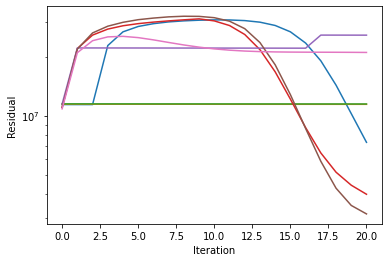

In [17]:
n = 7
dim = 1000
tolerance = 4E-3
graphs = []
for i in range(n):
    A = jnp.diagflat(jnp.array(random.randint(-200, 200, dim)))
    C = jnp.array(10 * random.randn(dim, dim))
    A = C.T @ A @ C
    answ = jnp.linalg.eigh(A)[0][0]
    riemanGD = predefine_GD(A)
    init_x = random.randn(dim)
    init_x = jnp.array(init_x / jnp.linalg.norm(init_x))
    vec, rs = riemanGD(init_x, tolerance, 20)
    graphs.append(plt.plot(rs))
    eival = make_rayleigh(A)(vec)
    print("Actual {}, found {}, err {}".format(answ, eival, jnp.abs(answ - eival)))

plt.xlabel("Iteration")
plt.ylabel("Residual")
plt.semilogy()
plt.show(graphs)

А теперь запретим матрицам $C$ не быть ортогональными:

Actual 1, found 1.6555993556976318, err 0.6555993556976318
Actual 1, found 2.5486338138580322, err 1.5486338138580322
Actual 2, found 2.557899236679077, err 0.5578992366790771
Actual 2, found 2.3236868381500244, err 0.3236868381500244
Actual 1, found 2.4670257568359375, err 1.4670257568359375
Actual 1, found 2.1753461360931396, err 1.1753461360931396
Actual 1, found 2.1798365116119385, err 1.1798365116119385
Actual 1, found 1.0681568384170532, err 0.06815683841705322
Actual 1, found 1.7457318305969238, err 0.7457318305969238
Actual 1, found 1.668211817741394, err 0.668211817741394


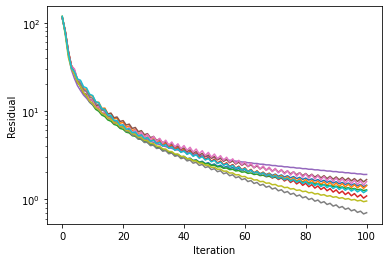

In [18]:
n = 10
dim = 1000
tolerance = 4E-3
graphs = []
for i in range(n):
    A = jnp.diagflat(jnp.array(random.randint(1, 400, dim)))
    answ = jnp.amin(jnp.diag(A))
    C = jnp.array(10 * random.randn(dim, dim))
    C = jnp.linalg.qr(C)[0]
    A = C.T @ A @ C
    riemanGD = predefine_GD(A)
    init_x = random.randn(dim)
    init_x = jnp.array(init_x / jnp.linalg.norm(init_x))
    vec, rs = riemanGD(init_x, tolerance, 100)
    graphs.append(plt.plot(rs))
    eival = make_rayleigh(A)(vec)
    print("Actual {}, found {}, err {}".format(answ, eival, jnp.abs(answ - eival)))

plt.xlabel("Iteration")
plt.ylabel("Residual")
plt.semilogy()
plt.show(graphs)

##### Вывод
Для плохих матриц сходимость приняла ислам, а для хороших
вполне пристойно за 100 итераций сходится к правильному собственному значению.
Примечательно так же то, что первые 10 итераций ошибка растёт, потом резко снижается,
и далее ведёт себя, как при обычном градиентном спуске. Чем обусловлено такое поведение,
я сказать затрудняюсь...

Предлагаю взять какую-нибудь плохую матрицу и посмотреть, за сколько итераций метод
для неё сойдётся к чему-то адекватному.

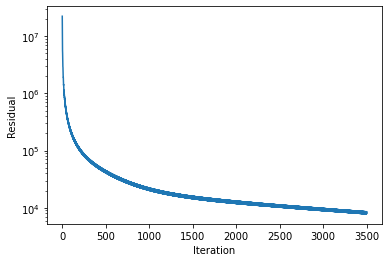

In [19]:
dim = 1000
tolerance = 4E-3
A = jnp.diagflat(jnp.array(random.randint(1, 400, dim)))
answ = jnp.amin(A)
C = jnp.array(10 * random.randn(dim, dim))
A = C.T @ A @ C
riemanGD = predefine_GD(A)
init_x = random.randn(dim)
init_x = jnp.array(init_x / jnp.linalg.norm(init_x))
vec, rs = riemanGD(init_x, tolerance, 3500)
plt.xlabel("Iteration")
plt.ylabel("Residual")
plt.semilogy()
plt.show(plt.plot(rs))

In [23]:
print("Found {}, actual {}".format(make_rayleigh(A)(vec), jnp.linalg.eigh(A)[0][0]))

Found 5016.33837890625, actual 5.341063499450684


Сошлось, блин.

### Ищем несколько собственных значений

Глобально идея та же самая, только теперь вместо одного вектора $x_k$ у нас
будет матрица с нормированными столбцами $X_k$, которую мы будем воспринимать
как коллекцию векторов, лежащих на сфере. Эту матрицу мы будем ортогонализовывать
на каждой итерации, чтобы разные столбцы сошлись к собственным векторам, лежащим
в разных собственных подпространствах.

Немного переделаем алгоритм: пусть у нас всё ещё есть фиксированная матрица
$A \in \mathbb{R}^{n\times n}$. Тогда новое "отношение Реллея" будет иметь вид
$f\colon S^{n-1} \to \mathbb{R}^m$ по правилу $X \mapsto diag(X^TAX)$, где $m$ —
сколько собственных значений мы хотим найти. Соответветственно, если
$X_0 \in (S^{n-1})^m$ — начальное приближение, то на $k+1$-ой итерации
алгоритма

1. Считаем $\nabla f(X_k)$ (матрица, где каждый столбец это $\nabla f(X_k^{(i)})$) методами autodiff;
2. Считаем $\nabla_R f(X_k)$ (аналогично) по правилу $\nabla_R f(X_k^{(i)}) = P_{T_{X_k^{(i)}}S^{n-1}}(\nabla f(X_k^{(i)}))$;
3. Вычисляем длину шага $\alpha_k^i$ при помощи Armijo backtracking для каждого столбца;
4. $X_{k+1} =\mathcal{R}_{X_k}(-\nabla_R f(X_k)\alpha_k) \to \min_{X \in (S^{n-1})^m} f(X)$;

Здесь $\alpha_k$ — диагональная матрица с длинами шагов, а
$\mathcal{R}_{X_k} \colon \mathbb{R}^{n\times m} \to (S^{n-1})^m$ — новая
ретракция по правилу $M \mapsto QR(X_k + M)$.

А теперь со всем этим дерьмом мы попытаемся взлететь....

P.S. Хорошая попытка, но такое отношение Реллея не получится продифференцировать.
Придётся вернуть старое отношение и применять его к каждому столбцу.


In [24]:
make_rayleigh = lambda A: lambda x: jnp.inner(x, A @ x)

def new_retraction(X, M):
    res = X + M
    return jnp.linalg.qr(res)[0]

make_residual = lambda A: lambda X: jnp.linalg.norm(A @ X - X @ (X.T @ (A @ X)))

In [25]:
def predefine_GD_multiple_eigenvals(A):
    rayleigh = make_rayleigh(A)
    residual = make_residual(A)

    def riemanGD_multiple_eigenvals(init, tol, max_iter = None, debug = False):
        X = init
        residuals = [residual(X)]
        iters = 0
        if debug == True:
            print("№\tresidual")
        while residual(X) > tol:
            regular_grad = jax.grad(rayleigh)
            rieman_grad = jnp.array([orthoprojector(X[:, i], regular_grad(X[:, i])) for i in range(X.shape[1])]).T
            alpha = jnp.array([armijo_backtracking(jnp.inner(X[:, i], A @ rieman_grad[:, i]) / rayleigh(rieman_grad[:, i]), rieman_grad[:, i], 1E-4, 0.8, rayleigh, X[:, i]) for i in range(X.shape[1])])
            # alpha = jnp.array([armijo_backtracking(10, rieman_grad[:, i], 1E-4, 0.8, rayleigh, X[:, i]) for i in range(X.shape[1])])
            X = new_retraction(X, -rieman_grad @ jnp.diagflat(alpha))
            iters += 1
            residuals.append(residual(X))
            if debug == True:
                print("{}\t{}".format(iters, residual(X)))
            if max_iter is not None and iters >= max_iter:
                break

        return X, residuals

    return riemanGD_multiple_eigenvals

In [28]:
print("Toy test: A = diag(24, 12, 0, -7)")
init_X = random.randn(4, 3)
init_X = jnp.linalg.qr(init_X)[0]
tolerance = 4E-3
A = jnp.diagflat(jnp.array([24, 12, 0, -7]))
riemanGD_multiple_eigenvals = predefine_GD_multiple_eigenvals(A)
vec = riemanGD_multiple_eigenvals(init_X, tolerance, 108)[0]

Toy test: A = diag(24, 12, 0, -7)


In [29]:
print(make_rayleigh(A)(vec[:, 0]))
print(make_rayleigh(A)(vec[:, 1]))
print(make_rayleigh(A)(vec[:, 2]))



-7.0
-1.696875e-07
12.000001


Жесть, оно сработало. Запускать его на больших тестах нет никакого желания, но оно
работает, а это уже больше, чем я ожидал....